In [77]:
import json
import numpy as np
from pyproj import Transformer
import pandas as pd
from shapely import wkt
from shapely.geometry import shape, Polygon, LineString, Point
from tqdm import tqdm
import sys
import networkx as nx
import geopandas as gpd
from shapely.strtree import STRtree
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

# The known overlap (in meters) between Sentinel-2 tiles when they are in the same UTM zone
known_x_overlap = 9840
known_y_overlap = 9780

# Load GeoJSON
with open("3rdparty/sentinel-2-grid/grid.geojson") as f:
    geojson_data = json.load(f)

with open("3rdparty/sentinel-2-grid/grid_pretty.geojson", "w") as f:
    json.dump(geojson_data, f, indent=2)

# Tiles dictionary with the structure you want
tiles = {}

to_wgs84 = {}
from_wgs84 = {}

def mean_angle(a1, a2):
    # Compute difference
    diff = a2 - a1

    # Wrap the difference to [-180, 180]
    while diff > 180:
        diff -= 360
    while diff < -180:
        diff += 360

    # Add half the (wrapped) difference to a1
    mid = a1 + diff / 2

    # Normalize result to [-180, 180]
    while mid > 180:
        mid -= 360
    while mid < -180:
        mid += 360

    return mid

def densify_and_project(polygon, from_wgs84, to_wgs84, threshold = 1.0):

    def distance(p1, p2):
        return np.hypot(p2[0]-p1[0], p2[1]-p1[1])

    # Extract coordinates from the polygon (excluding the closing point)
    coords = list(polygon.exterior.coords)
    i = 0
    while i < len(coords) - 1:
        utm_mid = ((coords[i][0] + coords[i+1][0])*0.5, (coords[i][1] + coords[i+1][1])*0.5)
        p0 = to_wgs84(*coords[i])
        p1 = to_wgs84(*coords[i+1])
        wgs84_mid = (mean_angle(p0[0], p1[0]), (p0[1] + p1[1])*0.5)
        wgs84_mid_in_utm = from_wgs84(*wgs84_mid)
        dist = distance(utm_mid, wgs84_mid_in_utm)
        if dist > threshold:
            coords.insert(i + 1, utm_mid)
            if len(coords) > 1000:
                print(list(polygon.exterior.coords))
                print([to_wgs84(x, y) for x, y in polygon.exterior.coords])
                #print(coords[i:i+3])
                raise ValueError("Too many points in polygon, consider increasing the threshold")
        else:
            i += 1

    projected_coords = [to_wgs84(x, y) for x, y in coords]
    return Polygon(projected_coords)

print("Loading tile geometries and densifying to WGS84")
#for feature in tqdm(geojson_data.get("features", [])):
for feature in tqdm(filter(lambda a: a["properties"]["id"][:2] in ("32", "33", "34", "35", "36", "37", "38"), geojson_data.get("features", []))):
    sys.stdout.flush()
    props = feature.get("properties", {})
    feature_id = props.get("id") or props.get("name") or "unknown"

    # Extract EPSG code (string)
    epsg_code = props.get("epsg")

    # Create UTM <-> WGS84 transforms
    if epsg_code not in to_wgs84:
        try:
            epsg_int = int(epsg_code)
            to_wgs84[epsg_code] = Transformer.from_crs(f"EPSG:{epsg_int}", "EPSG:4326", always_xy=True).transform
            from_wgs84[epsg_code] = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg_int}", always_xy=True).transform
        except ValueError:
            print(f"Invalid EPSG code: {epsg_code}")

    # Parse the UTM polygon from utmWkt if available
    utm_polygon = None
    utm_wkt = props.get("utmWkt")
    if utm_wkt:
        try:
            utm_geom = wkt.loads(utm_wkt)
            # Unwrap single-polygon multipolygons
            if utm_geom.geom_type == "MultiPolygon" and len(utm_geom.geoms) == 1:
                utm_geom = utm_geom.geoms[0]
            utm_polygon = utm_geom
        except Exception as e:
            print(f"Error parsing utmWkt for feature {feature_id}: {e}")
  
    # Store everything in tiles dict
    tile = {
        "id": feature_id,
        "utm_polygon": utm_polygon,
        "dense_wgs84_polygon": densify_and_project(utm_polygon, from_wgs84[epsg_code], to_wgs84[epsg_code]),
        "epsg_code": epsg_code,
    }

    #for other_tile in tiles.values():
    #    # Check if the polygons overlap
    #    if tile["epsg_code"] == other_tile["epsg_code"]:            
    #        None  # They are in the same UTM zone. There will be no intersection (since we shrank the polygons)
    #    elif tile["dense_wgs84_polygon"].intersects(other_tile["dense_wgs84_polygon"]):
    #        overlap_graph.add_edge(tile["id"], other_tile["id"])

    tiles[feature_id] = tile


Loading tile geometries and densifying to WGS84


6596it [00:04, 1514.29it/s]


In [78]:
print("Finding intersecting tiles")
gdf = gpd.GeoDataFrame(tiles.values())
gdf.set_index("id", inplace=True)
gdf.set_geometry("dense_wgs84_polygon", crs="EPSG:4326", inplace=True)
pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
# Add pairs to graph
intersect_graph = nx.Graph()
for i, j in pairs:
    if i < j:
        intersect_graph.add_edge(gdf.index[i], gdf.index[j])

print(f"Average number of intersecting neighbors: {(len(pairs)-len(tiles))/len(tiles)}")

Finding intersecting tiles
Average number of intersecting neighbors: 8.084596725288053


In [79]:
tiles

{'32CMA': {'id': '32CMA',
  'utm_polygon': <POLYGON ((399960 1600000, 399960 1490200, 509760 1490200, 509760 1600000, 3...>,
  'dense_wgs84_polygon': <POLYGON ((5.38 -75.657, 5.365 -75.719, 5.349 -75.78, 5.334 -75.841, 5.318 -...>,
  'epsg_code': '32732'},
 '32CMB': {'id': '32CMB',
  'utm_polygon': <POLYGON ((399960 1700020, 399960 1590220, 509760 1590220, 509760 1700020, 3...>,
  'dense_wgs84_polygon': <POLYGON ((5.588 -74.762, 5.575 -74.824, 5.561 -74.885, 5.547 -74.947, 5.534...>,
  'epsg_code': '32732'},
 '32CMC': {'id': '32CMC',
  'utm_polygon': <POLYGON ((399960 1800040, 399960 1690240, 509760 1690240, 509760 1800040, 3...>,
  'dense_wgs84_polygon': <POLYGON ((5.773 -73.867, 5.761 -73.929, 5.749 -73.99, 5.737 -74.052, 5.724 ...>,
  'epsg_code': '32732'},
 '32CMD': {'id': '32CMD',
  'utm_polygon': <POLYGON ((399960 1900000, 399960 1790200, 509760 1790200, 509760 1900000, 3...>,
  'dense_wgs84_polygon': <POLYGON ((5.938 -72.973, 5.927 -73.034, 5.916 -73.096, 5.905 -73.157, 5.894...

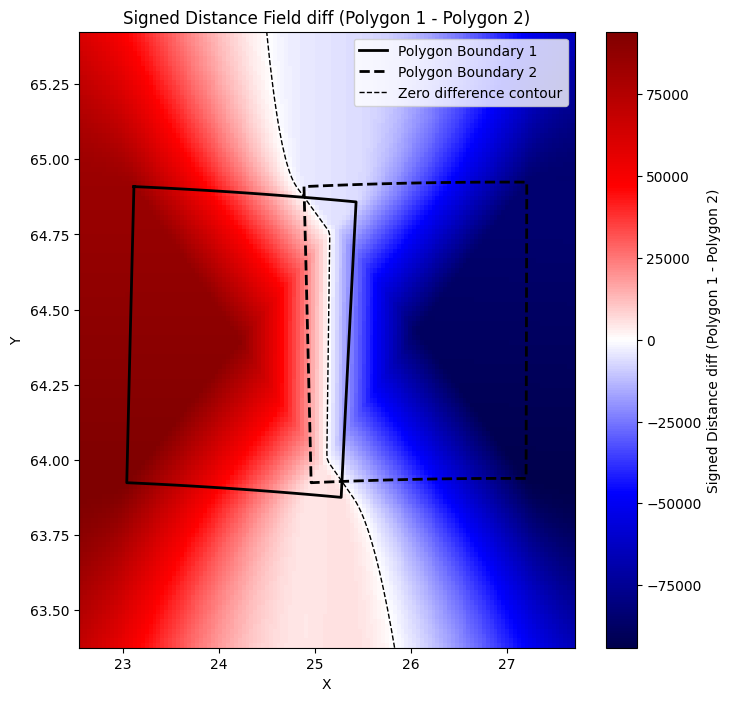

In [145]:
def build_edge_segments_and_tree(polygon):
    """
    Break the polygon's exterior into LineString segments.
    
    Args:
        polygon (shapely.geometry.Polygon): The polygon.

    Returns:
        tuple: A list of LineString segments and a spatial index (STRtree).
    """
    coords = list(polygon.exterior.coords)
    edge_segments = [LineString([coords[i], coords[i+1]]) for i in range(len(coords) - 1)]

    # Create spatial index
    tree = STRtree(edge_segments)

    return edge_segments, tree

def shortest_distance_with_strtree(polygon, edge_segments, tree, point_coords):
    """
    Compute the shortest distance from a point to a polygon edge using STRtree.
    Returns positive distance for points inside the polygon and negative distance for points outside.

    Args:
        polygon_coords (list of tuple): List of (x, y) defining the polygon.
        point_coords (tuple): (x, y) of the point.

    Returns:
        float: Shortest distance (positive for inside points, negative for outside points).
    """
    point = Point(point_coords)
    
    # In Shapely 2.1.1, nearest() returns the index of the nearest geometry
    nearest_idx = tree.nearest(point)
    
    # Get the actual nearest edge using the index
    nearest_edge = edge_segments[nearest_idx]
    
    # Calculate the distance
    distance = point.distance(nearest_edge)
    
    # Determine if point is inside or outside the polygon
    if not polygon.contains(point):
        distance = -distance  # Negative distance for points outside
    
    return distance

def transform_grid(coords, f):
    # Flatten for transformation
    x_flat = coords[..., 0].ravel()
    y_flat = coords[..., 1].ravel()

    # Transform coordinates
    x_trans, y_trans = f(x_flat, y_flat)

    # Reshape to original grid shape
    return np.stack((x_trans.reshape(coords.shape[:2]), y_trans.reshape(coords.shape[:2])), axis=-1)    

def plot_signed_distance_field(x_range, y_range, polygon_wgs84_coords1, utm_polygon1, from_wgs84_1, polygon_wgs84_coords2=None, utm_polygon2=None, from_wgs84_2=None, resolution=128):
    """
    Plots the signed distance field for a polygon using imshow.

    Args:
        polygon_coords (list of tuple): List of (x, y) defining the polygon.
        x_range (tuple): (min_x, max_x) for the plot.
        y_range (tuple): (min_y, max_y) for the plot.
        resolution (int): Number of points to sample in each dimension.
    """
    edge_segments1, tree1 = build_edge_segments_and_tree(utm_polygon1)
    if polygon_wgs84_coords2 is not None:
        edge_segments2, tree2 = build_edge_segments_and_tree(utm_polygon2)

    x_min, x_max = x_range
    y_min, y_max = y_range

    x_coords = np.linspace(x_min, x_max, resolution)
    y_coords = np.linspace(y_min, y_max, resolution)

    yy, xx = np.meshgrid(y_coords, x_coords, indexing='ij')

    # Stack along the last axis to create (len(x), len(y), 2)
    coordinates = np.stack((xx, yy), axis=-1)
    coordinates1 = transform_grid(coordinates, from_wgs84_1)
    if polygon_wgs84_coords2 is not None:
        coordinates2 = transform_grid(coordinates, from_wgs84_2)

    Z1 = np.apply_along_axis(lambda point_coords: shortest_distance_with_strtree(utm_polygon1, edge_segments1, tree1, point_coords), axis=2, arr=coordinates1)
    if polygon_wgs84_coords2 is not None:
        Z2 = np.apply_along_axis(lambda point_coords: shortest_distance_with_strtree(utm_polygon2, edge_segments2, tree2, point_coords), axis=2, arr=coordinates2)
        Z = Z1 - Z2
    else:
        Z = Z1

    fig, ax = plt.subplots(figsize=(8, 8))

    # Determine the maximum absolute value for symmetric range
    max_abs_z = np.max(np.abs(Z))
    vmax = max_abs_z
    vmin = -max_abs_z

    # Use imshow to plot the signed distance field
    # extent argument sets the spatial extent of the image
    # origin='lower' sets the origin to the lower left corner
    imshow_plot = plt.imshow(Z, origin='lower', extent=[x_min, x_max, y_min, y_max], cmap='seismic', vmin=vmin, vmax=vmax, aspect='auto')
    if polygon_wgs84_coords2 is not None:
      plt.colorbar(imshow_plot, ax=ax, label='Signed Distance diff (Polygon 1 - Polygon 2)')
    else:  
      plt.colorbar(imshow_plot, ax=ax, label='Signed Distance')

    # Plot the polygon boundary
    poly_x, poly_y = zip(*polygon_wgs84_coords1)
    plt.plot(poly_x, poly_y, 'k-', linewidth=2, label='Polygon Boundary 1')
    if polygon_wgs84_coords2 is not None:
        poly2_x, poly2_y = zip(*polygon_wgs84_coords2)
        plt.plot(poly2_x, poly2_y, 'k--', linewidth=2, label='Polygon Boundary 2')

    # Plot zero diff contour with a thin dashed line and add to the legend after Polygon 1 (and 2)
    zero_contour = plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='dashed', linewidths=1)

    # Create a proxy artist for the zero difference contour to add to the legend
    zero_contour_proxy = Line2D([], [], color='k', linestyle='dashed', linewidth=1, label='Zero difference contour')
    min_contour1_proxy = Line2D([], [], color='k', linestyle='solid', linewidth=0.5, label='Shrunken polygon 1')
    min_contour2_proxy = Line2D([], [], color='k', linestyle='dashed', linewidth=0.5, label='Shrunken polygon 2')

    # Get existing handles and labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()

    # Add the proxy artist to the handles
    handles.append(zero_contour_proxy)

    if polygon_wgs84_coords2 is not None:
        plt.title('Signed Distance Field diff (Polygon 1 - Polygon 2)')
    else:
      plt.title('Signed Distance Field')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(handles=handles)
    plt.show()
    
#tile1_id = "35VLH"
tile1_id = "34WFS"
# Find wgs84 bounding box of neighbors intersect_graph.neighbors(tile1_id)
intersecting_tiles = list(intersect_graph.neighbors(tile1_id))
tile2_id = list(intersect_graph.neighbors(tile1_id))[5]  # 2nd neighbor of tile1_id
neighborhood_bounds = gdf.loc[[tile1_id, tile2_id]].geometry.total_bounds
polygon1 = tiles[tile1_id]["dense_wgs84_polygon"]
polygon2 = tiles[tile2_id]["dense_wgs84_polygon"]
poly_coords1 = list(polygon1.exterior.coords)
poly_coords2 = list(polygon2.exterior.coords)
plot_signed_distance_field((neighborhood_bounds[0]-0.5, neighborhood_bounds[2]+0.5), (neighborhood_bounds[1]-0.5, neighborhood_bounds[3]+0.5), poly_coords1, tiles[tile1_id]["utm_polygon"], from_wgs84[tiles[tile1_id]["epsg_code"]], poly_coords2, tiles[tile2_id]["utm_polygon"], from_wgs84[tiles[tile2_id]["epsg_code"]])
#def plot_signed_distance_field(x_range, y_range, polygon_coords1, utm_polygon1, from_wgs84_1, polygon_coords2=None, utm_polygon2=None, from_wgs84_2=None, resolution=512):


[[[60.         22.5       ]
  [60.01181102 22.5       ]
  [60.02362205 22.5       ]
  ...
  [61.47637795 22.5       ]
  [61.48818898 22.5       ]
  [61.5        22.5       ]]

 [[60.         22.52362205]
  [60.01181102 22.52362205]
  [60.02362205 22.52362205]
  ...
  [61.47637795 22.52362205]
  [61.48818898 22.52362205]
  [61.5        22.52362205]]

 [[60.         22.54724409]
  [60.01181102 22.54724409]
  [60.02362205 22.54724409]
  ...
  [61.47637795 22.54724409]
  [61.48818898 22.54724409]
  [61.5        22.54724409]]

 ...

 [[60.         25.45275591]
  [60.01181102 25.45275591]
  [60.02362205 25.45275591]
  ...
  [61.47637795 25.45275591]
  [61.48818898 25.45275591]
  [61.5        25.45275591]]

 [[60.         25.47637795]
  [60.01181102 25.47637795]
  [60.02362205 25.47637795]
  ...
  [61.47637795 25.47637795]
  [61.48818898 25.47637795]
  [61.5        25.47637795]]

 [[60.         25.5       ]
  [60.01181102 25.5       ]
  [60.02362205 25.5       ]
  ...
  [61.47637795 25.5     

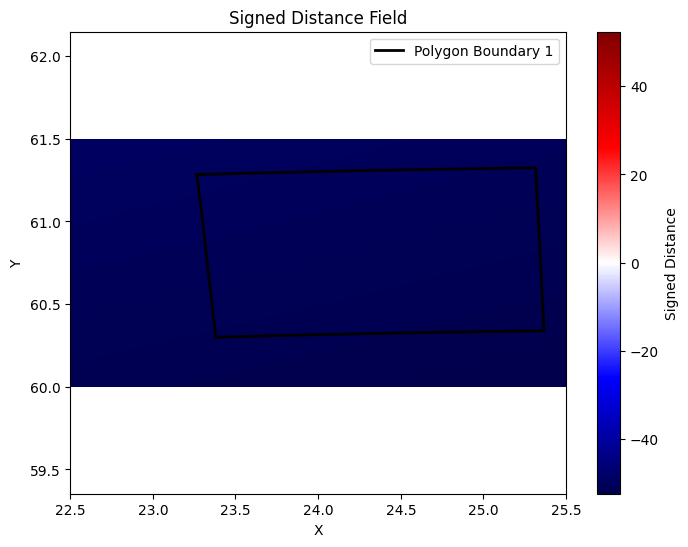

Overlap between 35VLH and 35VMG
Overlap between 35VLH and 35VMH
Overlap between 35VLH and 35VMJ
Overlap between 35VLH and 34VFM
Overlap between 35VLH and 34VFN
Overlap between 35VLH and 35VLH
Overlap between 35VLH and 34VFP
Overlap between 35VLH and 35VLG
Overlap between 35VLH and 35VLJ


<Axes: >

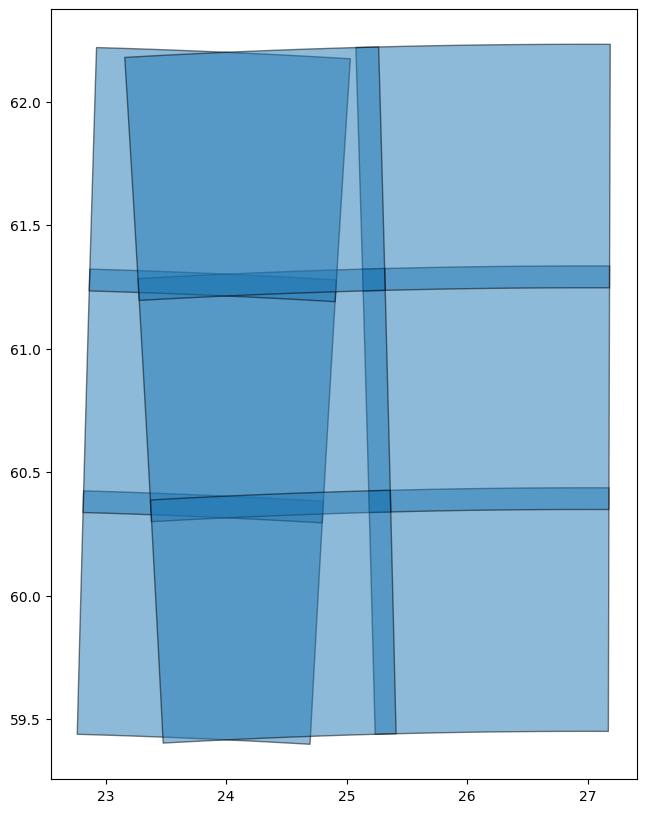

In [ ]:
pairs = gdf.sindex.query(gdf.geometry.values, predicate="intersects", output_format='indices').T
#print pair ids
overlaps_35vlh = []
for i, j in pairs:
    if gdf.index[i] == "35VLH":
        print(f"Overlap between {gdf.index[i]} and {gdf.index[j]}")
        overlaps_35vlh.append(gdf.index[j])
# Plot those that overlapped
gdf_overlaps = gdf.loc[overlaps_35vlh + ["35VLH"]]
gdf_overlaps.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)



In [3]:
overlaps = gdf.sindex.query_bulk(gdf.geometry, predicate='intersects')

AttributeError: 'SpatialIndex' object has no attribute 'query_bulk'

In [47]:
matches[0,:20]
matches[1,:20]

array([19018, 19019, 18088, 19034, 18107, 18067, 18078, 18068, 18079,
       17143, 18089, 17141, 17142, 17144, 17153, 17128, 16188, 17129,
       16189, 16198])

In [3]:
print("Saving densified tiles to GeoJSON")
# Convert tiles to GeoDataFrame, using the dense WGS84 polygons
dense_tiles = {
    tile_id: {
        "geometry": tile["dense_wgs84_polygon"],
        "id": tile_id,
        "epsg_code": tile["epsg_code"]
    }
    for tile_id, tile in tiles.items()
}
gdf = gpd.GeoDataFrame(dense_tiles).T
gdf.set_geometry("geometry", inplace=True)
gdf.set_crs("EPSG:4326", inplace=True)
gdf.to_file("3rdparty/sentinel-2-grid/densified_grid.geojson", driver="GeoJSON")


Saving densified tiles to GeoJSON


In [ ]:

# Save shrunken polygons to GeoJSON
output_geojson = {
    "type": "FeatureCollection",
    "features": []
}
for tile in tiles.values():
    # Project utm polygon to WGS84 without densification
    feature = {
        "type": "Feature",
        "properties": {
            "id": tile["id"],
            "epsg": tile["epsg_code"]
        },
        "geometry": gpd.GeoSeries(
            [Polygon([to_wgs84[tile["epsg_code"]](x, y) for x, y in list(tile["utm_polygon"].exterior.coords)])]
        ).__geo_interface__
    }
    output_geojson["features"].append(feature)
with open("3rdparty/sentinel-2-grid/shrunken_grid.geojson", "w") as f:
    json.dump(output_geojson, f, indent=2)

In [113]:
print("Neighbors of 35VLH:", list(overlap_graph.neighbors("35VLH")))

Neighbors of 35VLH: ['34VFM', '34VFN', '34VFP']


81


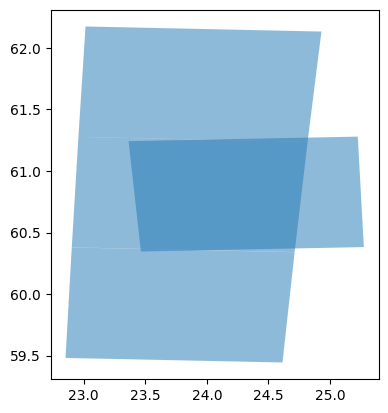

In [121]:
src = [{"geometry":tiles[tile_id]['dense_wgs84_polygon']} for tile_id in overlap_graph.neighbors("35VLH")]
src.append({"geometry":tiles["35VLH"]['dense_wgs84_polygon']})
df = gpd.GeoDataFrame(src)
df.plot(alpha=0.5)
[tiles[tile_id] for tile_id in overlap_graph.neighbors("35VLH")]

print(len(tiles['34VFM']['dense_wgs84_polygon'].exterior.coords))